<a href="https://colab.research.google.com/github/vpaula07/RossmannSalesForescast/blob/main/rossmann_store_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Engenharia de Software para Ciência de Dados - PUC-Rio**

**Problemas de Regressão**

Vanessa Paula dos Santos

# **Problema de Negócio**

Rossmann opera mais de 3.000 drogarias em 7 países europeus. Atualmente, os gerentes de loja da Rossmann têm a tarefa de prever suas vendas diárias com até seis semanas de antecedência. As vendas da loja são influenciadas por muitos fatores, incluindo promoções, competição, feriados escolares e estaduais, sazonalidade e localidade. Com milhares de gerentes individuais prevendo vendas com base em suas circunstâncias únicas, a precisão dos resultados pode ser bastante variada.

**Campos de dados**

A maioria dos campos é autoexplicativa. A seguir estão as descrições para aqueles que não são.

Id - um Id que representa um (Store, Date) duple dentro do conjunto de teste

Store - um ID único para cada loja

Sales - o volume de negócios em qualquer dia (isto é o que você está prevendo)

Customers - o número de clientes em um determinado dia

Open -  um indicador para saber se a loja estava aberta: 0 = fechada, 1 = aberta

StateHoliday - indica um feriado estadual. Normalmente todas as lojas, com poucas exceções, fecham nos feriados estaduais. Observe que todas as escolas fecham nos feriados e finais de semana. a = feriado, b = feriado da Páscoa, c = Natal, 0 = Nenhum

SchoolHoliday - indica se (loja, data) foi afetado pelo fechamento de escolas públicas

StoreType - diferencia entre 4 modelos de loja diferentes: a, b, c, d

Assortment - descreve um nível de sortimento: a = básico, b = extra, c = estendido

CompetitionDistance - distância em metros até a loja concorrente mais próxima

CompetitionOpenSince[Month/Year] - fornece o ano e mês aproximados em que o concorrente mais próximo foi aberto

Promo - indica se uma loja está fazendo uma promoção naquele dia

Promo2 - Promo2 é uma promoção contínua e consecutiva para algumas lojas: 0 = a loja não está participando, 1 = a loja está participando

Promo2Since[Year/Week] - descreve o ano e a semana em que a loja começou a participar da Promo2

PromoInterval - descreve os intervalos consecutivos em que a Promo2 é iniciada, nomeando os meses em que a promoção é reiniciada. Por exemplo. "Fev, maio, agosto, novembro" significa que cada rodada começa em fevereiro, maio, agosto, novembro de qualquer ano para aquela loja

Processo para baixar o arquivo do Kaggle para o google.colab:

**Dataset:**
https://www.kaggle.com/c/rossmann-store-sales

In [ ]:
!pip install kaggle; #caso seja necessário atualizar a biblioteca no google colab

from google.colab import files
files.upload() #enviar o arquivo kaggle.json

#antes de importar o dataset nós iremos provisionar o local de armazenamento
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
#Alterar a permissão para evitar o aviso durante a partida da ferramenta Kaggle
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

#Aceitar a competição e copiar o endereço da API para o download do dataset
!kaggle competitions download -c rossmann-store-sales

#Descompactar o arquivo baixado
!unzip \*.zip  && rm *.zip

Saving kaggle.json to kaggle.json
  0% 0.00/192k [00:00<?, ?B/s]
100% 192k/192k [00:00<00:00, 59.8MB/s]
  0% 0.00/44.0k [00:00<?, ?B/s]
100% 44.0k/44.0k [00:00<00:00, 39.7MB/s]
  0% 0.00/310k [00:00<?, ?B/s]
100% 310k/310k [00:00<00:00, 94.8MB/s]
 89% 6.00M/6.71M [00:00<00:00, 62.2MB/s]
100% 6.71M/6.71M [00:00<00:00, 58.7MB/s]
Archive:  test.csv.zip
  inflating: test.csv                

Archive:  train.csv.zip
  inflating: train.csv               

2 archives were successfully processed.


# **0.0 Imports**

In [ ]:
!pip install inflection

In [ ]:
#Imports
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import xgboost as xgb
import random as rds
import datetime

from matplotlib            import pyplot as plt
from IPython.core.display  import HTML
from IPython.display       import Image

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error


In [ ]:
#Helper Functions
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    #display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
jupyter_settings();


import warnings
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


In [ ]:
#Loading data
df_sales_raw = pd.read_csv('train.csv', low_memory=False)
df_store_raw = pd.read_csv('store.csv', low_memory =False)

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# **1.0. DESCRICAO DOS DADOS**

In [ ]:
df1 = df_raw.copy()

**1.1 Rename Columns**

In [ ]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

**1.2 Data Dimensions**

In [ ]:
print('Number of rows:{}'.format(df1.shape[0]))
print('Number of columns:{}'.format(df1.shape[1]))

Number of rows:1017209
Number of columns:18


**1.3 Data Types**

In [ ]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

**1.4 Check NA**

In [ ]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

**1.5 Fillout NA**

In [ ]:
df1['competition_distance'].max()

75860.0

In [ ]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan( x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval
month_map = {1:'Jan', 2:'Fev', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

df1['promo_interval'].fillna(0,inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval']==0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [ ]:
df1.sample(5).T

,798155,646327,669908,400573,510153
store,601,413,579,683,269
day_of_week,2,5,5,3,1
date,2013-07-16 00:00:00,2013-11-29 00:00:00,2013-11-08 00:00:00,2014-07-09 00:00:00,2014-03-31 00:00:00
sales,4686,8684,9007,6818,16837
customers,392,1015,984,752,1863
open,1,1,1,1,1
promo,1,0,1,0,1
state_holiday,0,0,0,0,0
school_holiday,1,0,0,1,0
store_type,d,a,c,a,a


In [ ]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

**1.6 Change Types**

In [ ]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [ ]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

**1.7 Descriptive Stastistical**

In [ ]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

**1.7.1 Numerical Attributes**

In [ ]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean )).T
ct2 = pd.DataFrame( num_attributes.apply( np.median )).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std)).T
d2 = pd.DataFrame( num_attributes.apply( min)).T
d3 = pd.DataFrame( num_attributes.apply( max)).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min())).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew())).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes', 'min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


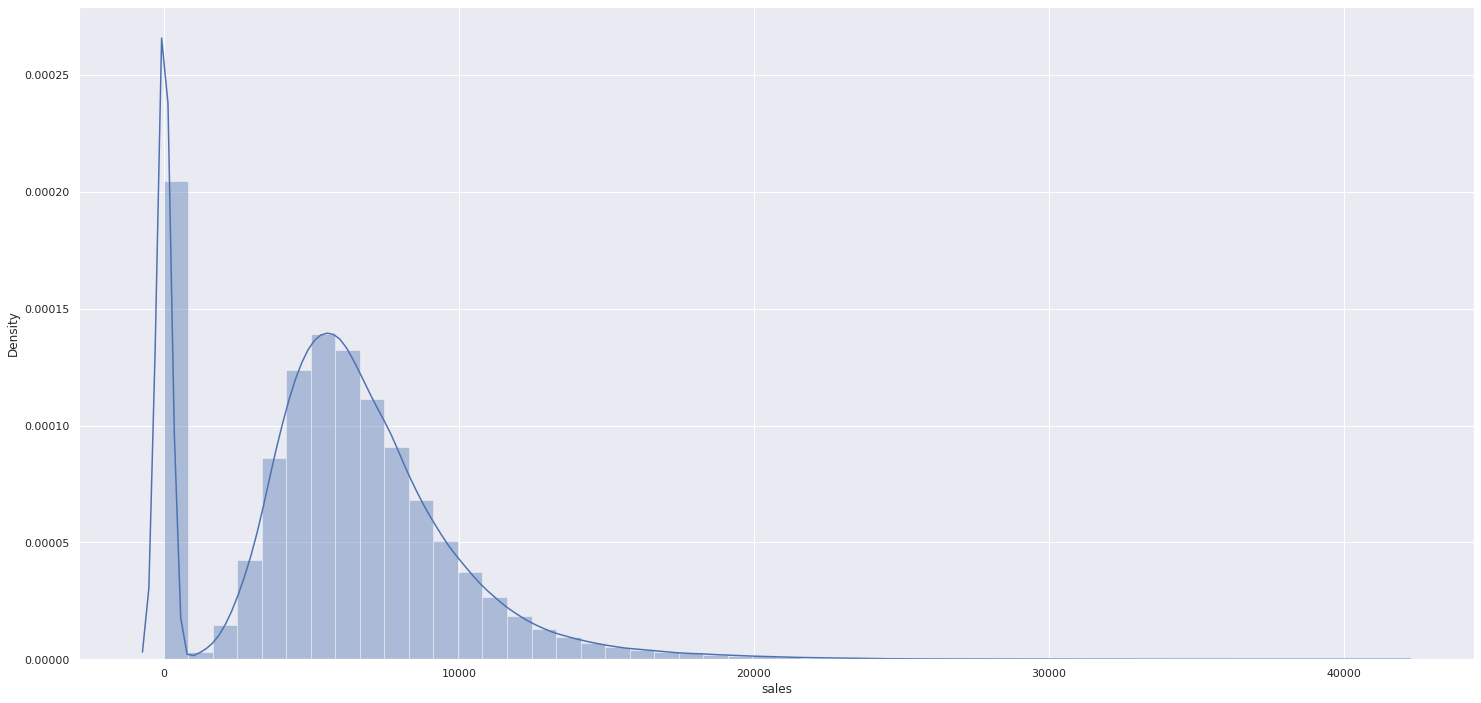

In [ ]:
sns.distplot(df1['sales'])

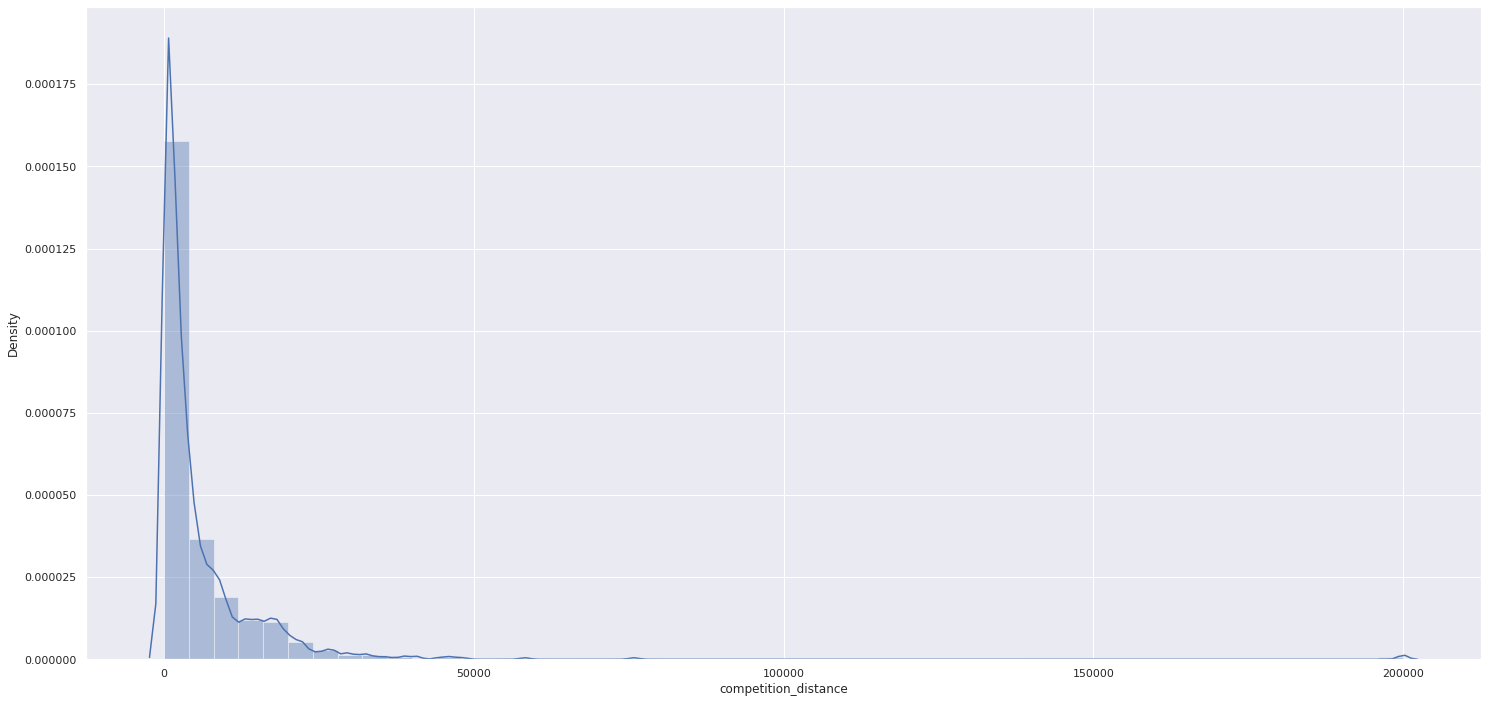

In [ ]:
sns.distplot(df1['competition_distance'])

**1.7.2 Cattegorical Attributes**

In [ ]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

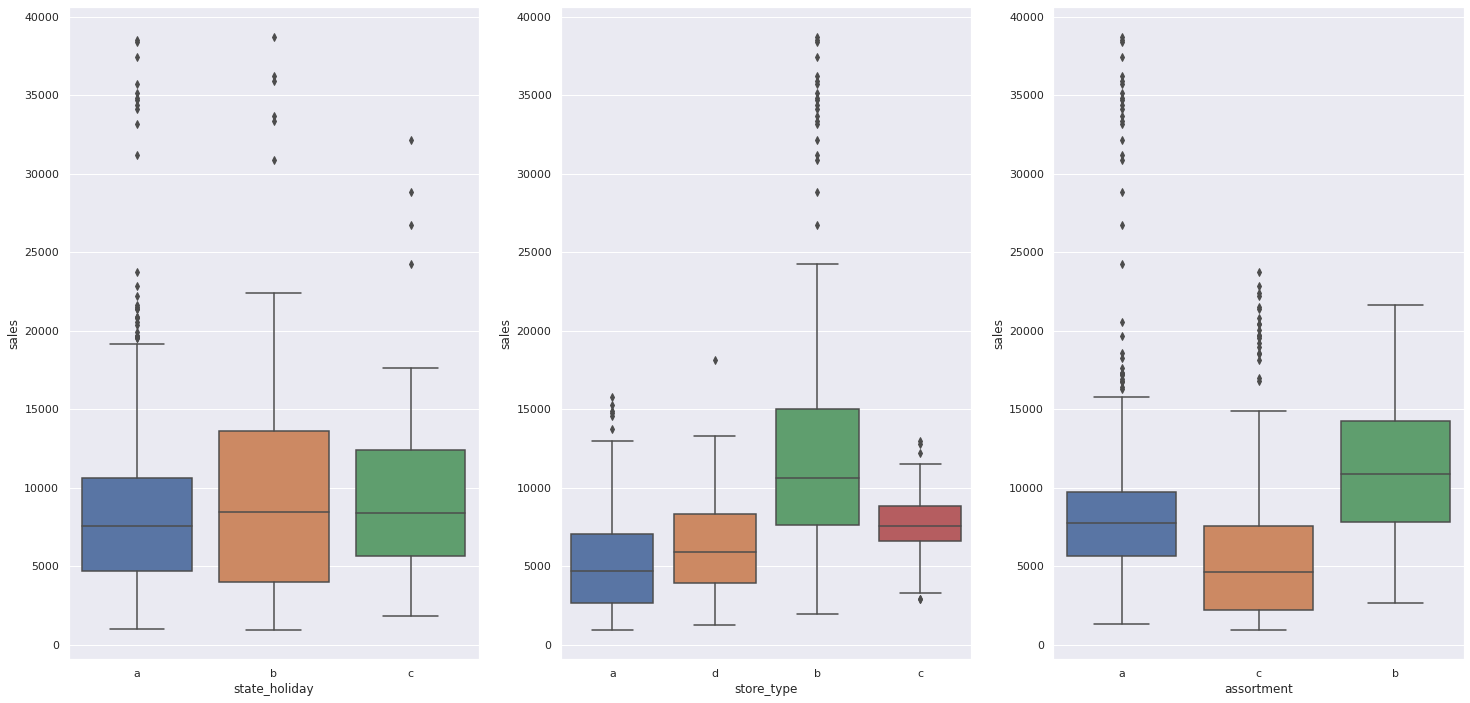

In [ ]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot( x='state_holiday', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.boxplot( x='store_type', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.boxplot( x='assortment', y='sales', data=aux1)

# **2.0 FEATURE ENGINEERING**

In [ ]:
df2 = df1.copy()

**2.1 Criação das Hipóteses**

**2.1.1 Hipótese Loja¶**
1. Lojas com número maior de funcionários deveriam vender mais.

2. Lojas com maior capacidade de estoque deveriam vender mais.

3. Lojas com maior porte deveriam vender mais.

4. Lojas com maior sortimento deveriam vender mais.

5. Lojas com competidores mais próximos deveriam vender menos.

6. Lojas com competidores à mais tenpo deveriam vender mais.

**2.1.2 Hipótese Produto**
1. Lojas que investiam mais em Marketing deveriam vender mais.

2. Lojas com maior exposição de produto deveriam vender mais.

3. Lojas com produtos com preço menor deveriam vender mais.

4. Lojas com promoção mais agressivas(descontos maiores), deveriam vender mais.

5. Lojas com promoção ativas por tempo deveriam vender mais.

6. Lojas com mais dias de promoção deveriam vender mais.

7. Lojas com mais promoções consecutivas deveriam vender mais.

**2.1.3 Hipótese Tempo**
1. Lojas abertas durante o feriado de Natal deveriam vender mais.

2. Lojas deveriam vender mais ao longo dos anos.

3. Lojas deveriam vender mais no segundo semestre do ano.

4. Lojas deveriam vender mais depois do dia 10 de cada mês.

5. Lojas deveriam vender menos aos finais de semana.

6. Lojas deveriam vender menos durante os feriados escolares.

**2.2 Lista Final de Hipóteses**
1. Lojas com maior sortimento deveriam vender mais.

2. Lojas com competidores mais próximos deveriam vender menos.

3. Lojas com competidores à mais tenpo deveriam vender mais.

4. Lojas com promoção ativas por tempo deveriam vender mais.

5. Lojas com mais dias de promoção deveriam vender mais.

6. Lojas com mais promoções consecutivas deveriam vender mais.

7. Lojas abertas durante o feriado de Natal deveriam vender mais.

8. Lojas deveriam vender mais ao longo dos anos.

9. Lojas deveriam vender mais no segundo semestre do ano.

10. Lojas deveriam vender mais depois do dia 10 de cada mês.

11. Lojas deveriam vender menos aos finais de semana.

12. Lojas deveriam vender menos durante os feriados escolares.

**2.2 Feature Engineering**

In [ ]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W')

#competition since
df2['competition_since'] =  df2.apply( lambda x: datetime.datetime(year= x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-'+ df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w')) - datetime.timedelta(days=7)
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply( lambda x: x.days).astype(int)

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x== 'a' else 'extra' if x=='b' else 'extended')

#state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public holiday' if x=='a'  else 'easter_holiday' if  x=='b' else 'Christmas' if x=='c' else 'regular_day' )

In [ ]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# **3.0 FILTRAGEM DE VARIÁVEIS**

In [ ]:
 df3 = df2.copy()

In [ ]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


**3.1 Filtragem das Linhas**

In [ ]:
df3 = df3[(df3['open'] !=0) & (df3['sales'] > 0)]

**3.2 Selecao das Colunas**

In [ ]:
cols_drop = ['open', 'customers', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [ ]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# **4.0 Análise Exploratória dos Dados**

In [ ]:
df4 = df3.copy()

**4.1 Analise Univariada**

**4.1.1 Response Variable**

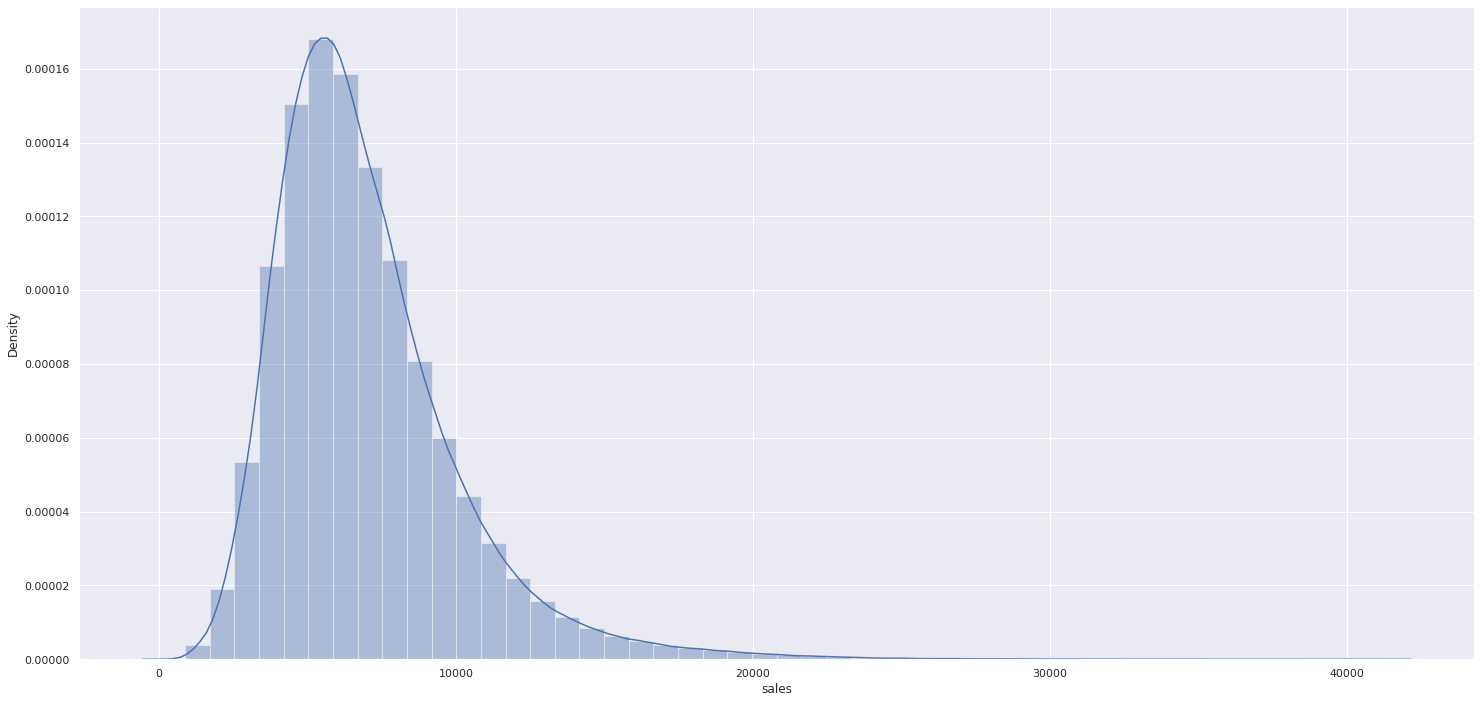

In [ ]:
sns.distplot(df4['sales'])

**4.1.2 Numerical Variable**

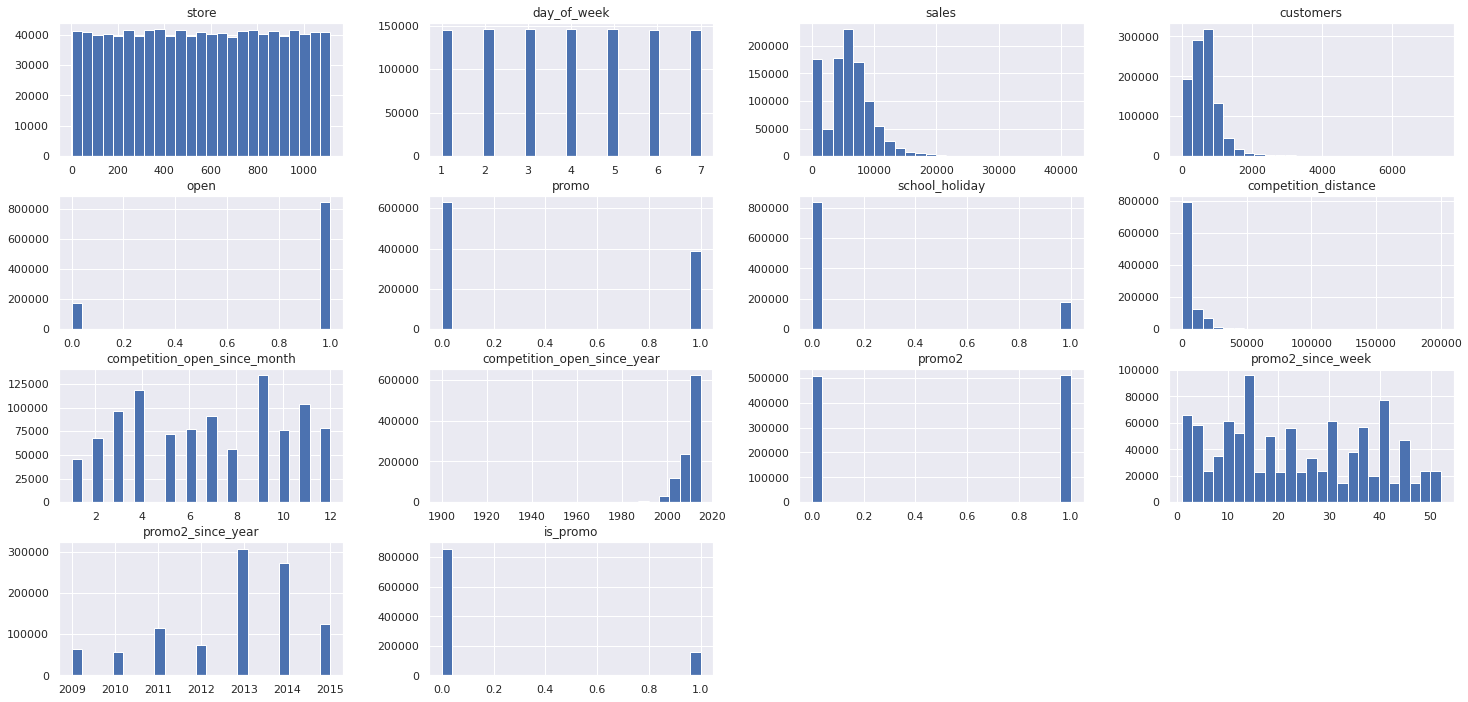

In [ ]:
num_attributes.hist(bins=25);

**4.1.3 Categorical Variable**

In [ ]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

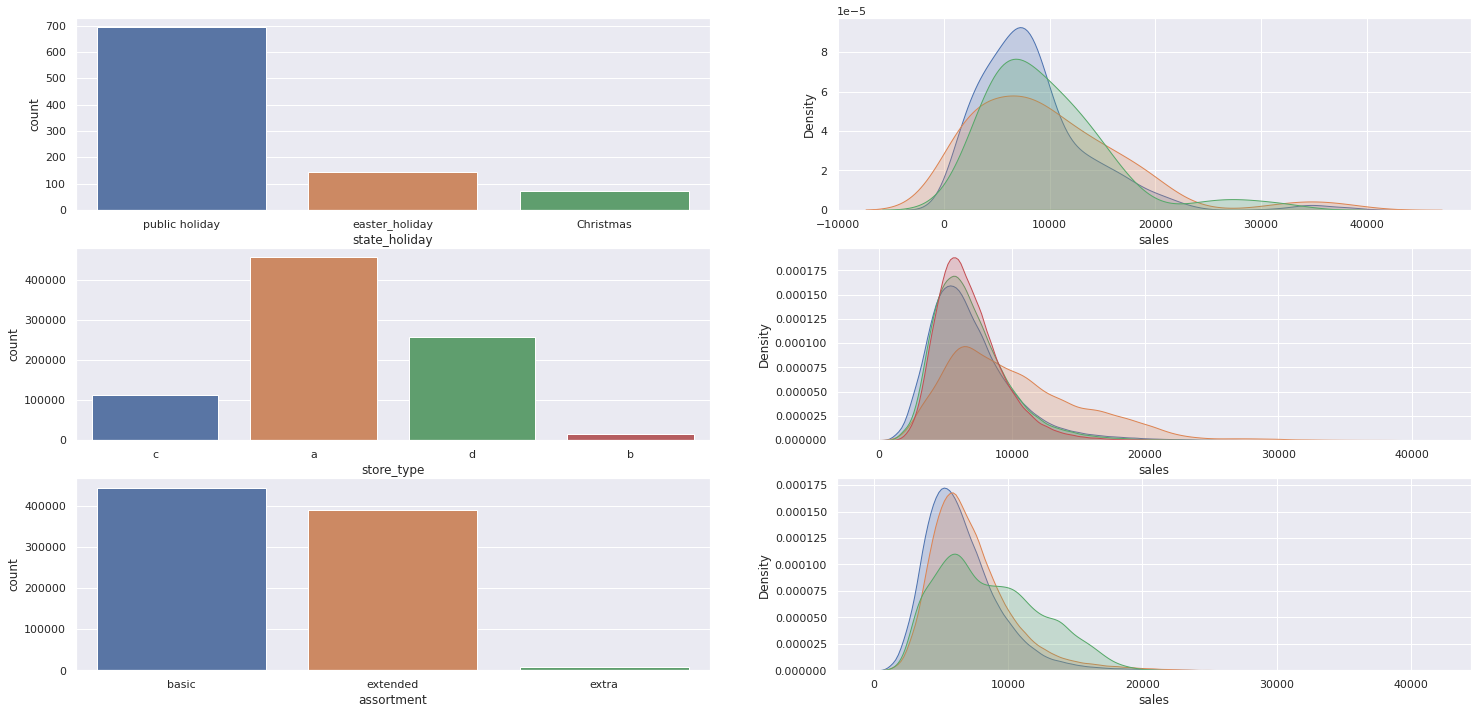

In [ ]:
#state holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public holiday']['sales'], label='public holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'Christmas']['sales'], label='Christmas', shade=True)

#store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

#assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)

**4.2 Análise Bivariada**

**H1. Lojas com maior sortimento deveriam vender mais.**
FALSA Lojas com MAIOIR SORTIMENTO vendem MENOS.

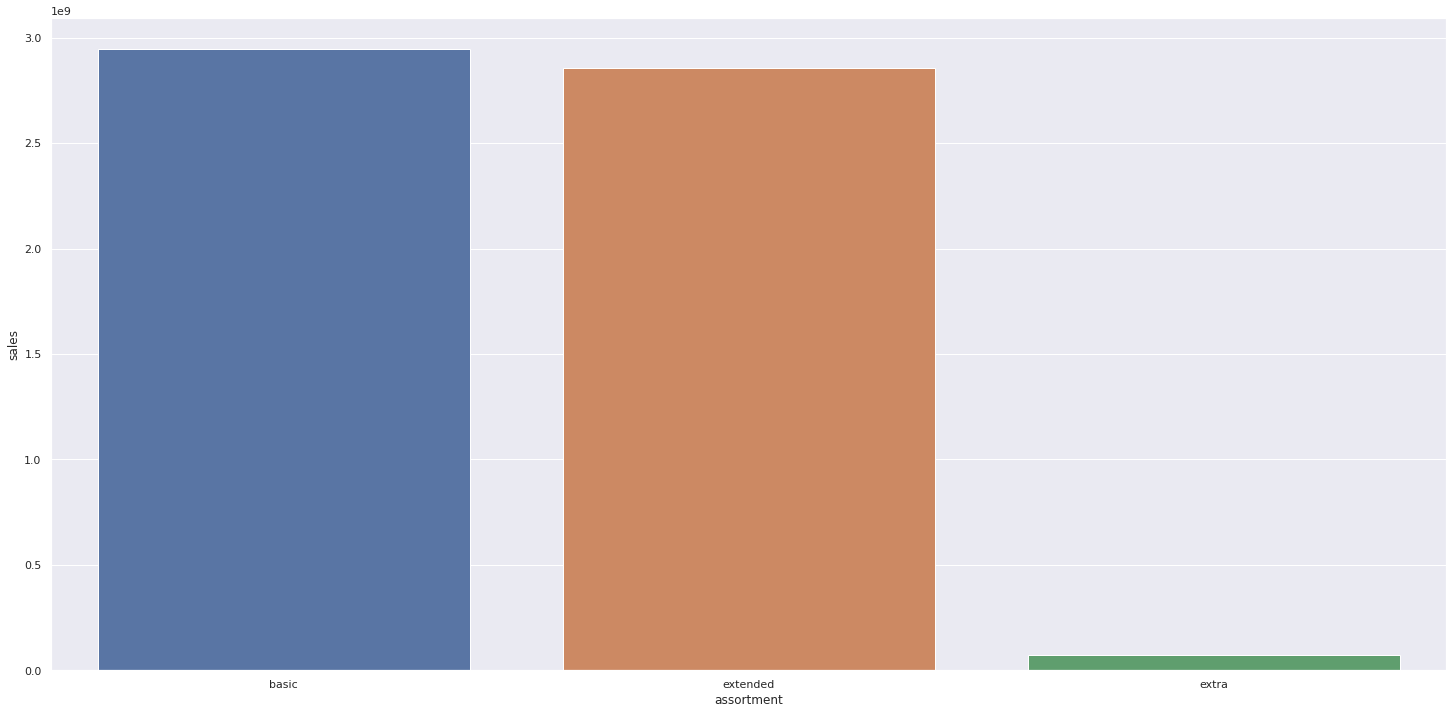

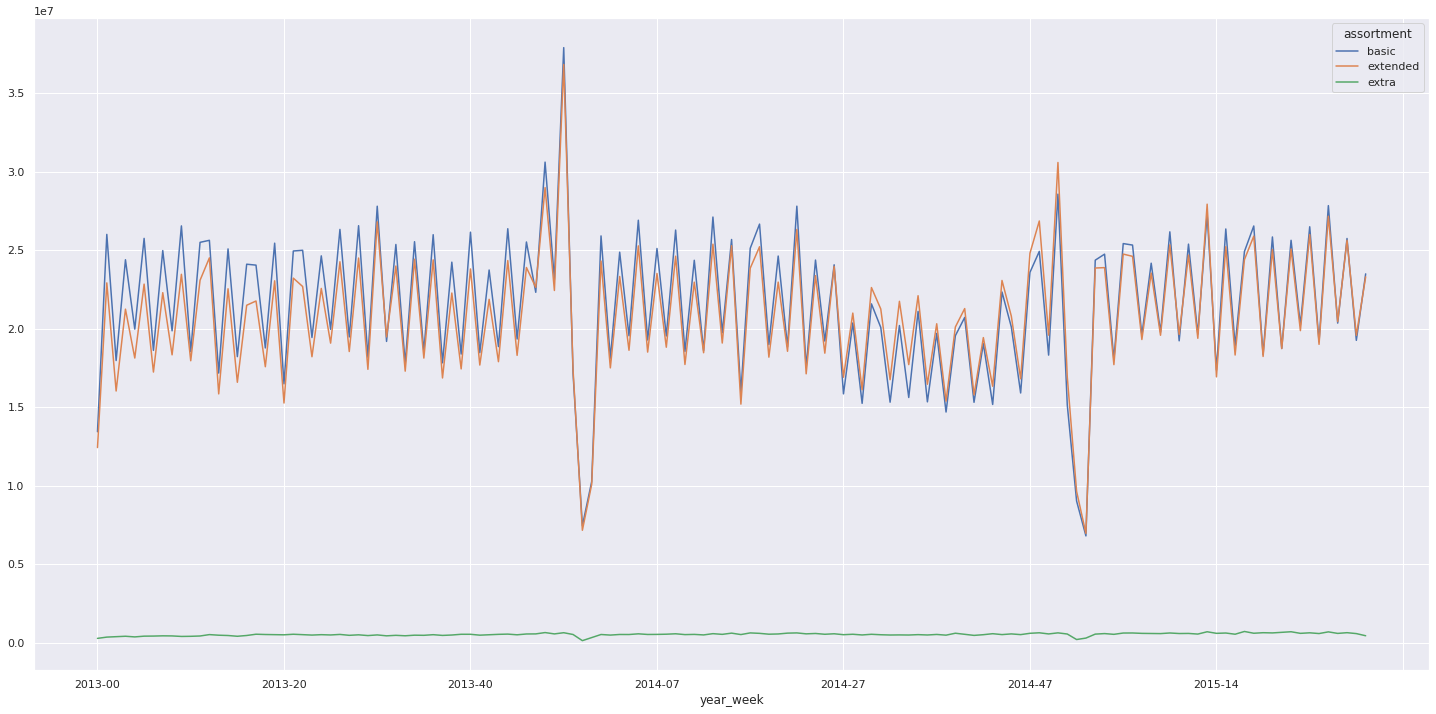

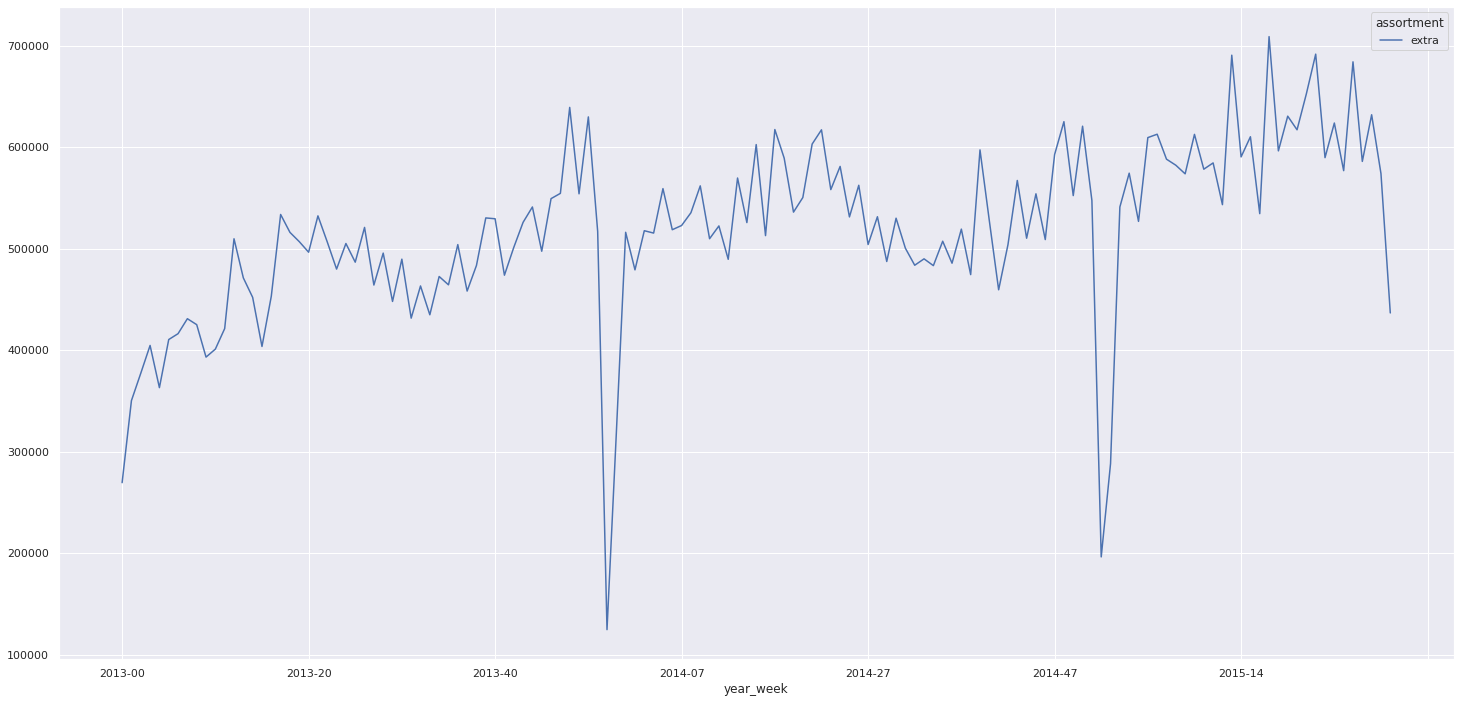

In [ ]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot('assortment', y='sales', data=aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index = 'year_week', columns='assortment', values='sales').plot()

**H2. Lojas com competidores mais próximos deveriam vender menos**
FALSA Lojas com COMPETIDORES MAIS PROXIMOS vendem MAIS

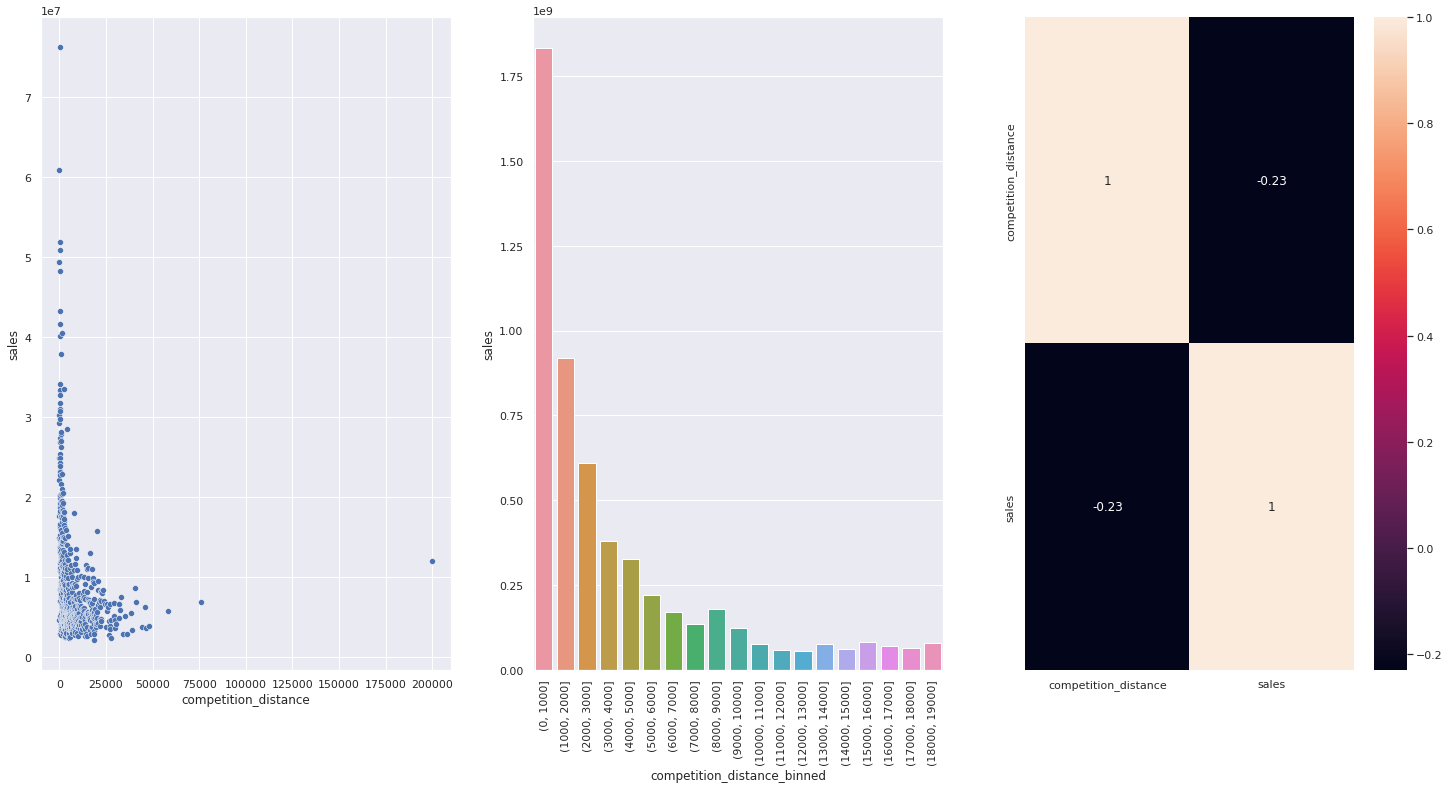

In [ ]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot(1,3,2)
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2)
plt.xticks(rotation=90);

plt.subplot(1,3,3)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True);

**H3. Lojas com competidores à mais tempo deveriam vender mais.**
FALSA Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS

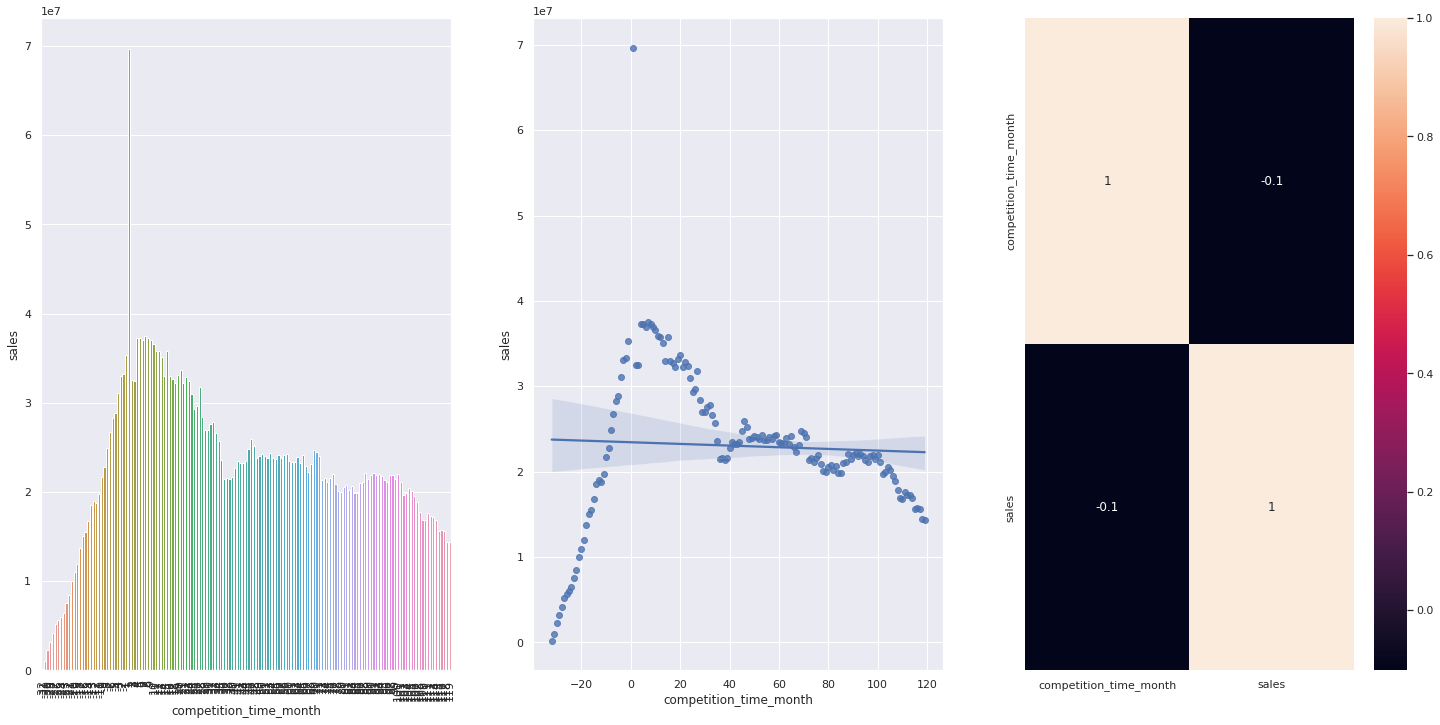

In [ ]:
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month']<120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x = 'competition_time_month', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(1,3,2)
sns.regplot(x = 'competition_time_month', y='sales', data = aux2);

plt.subplot(1,3,3)
x = sns.heatmap(aux1.corr(method = 'pearson'), annot= True);

**H4. Lojas com promoções ativas por mais tempo deveriam vender mais.**
FALSA Lojas com PROMOÇOES ATIVAS A MAIS TEMPO vendem MENOS

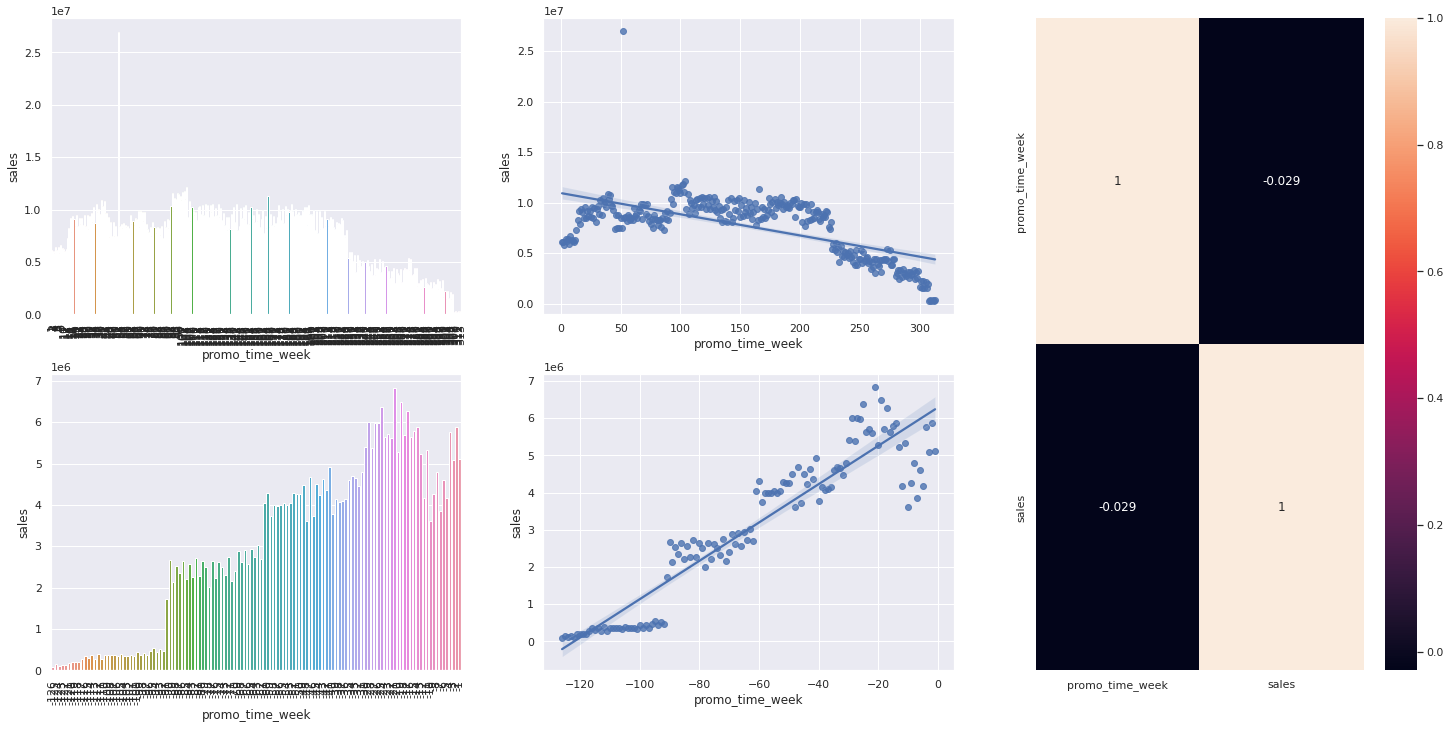

In [ ]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2,3)
plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] #promo extendido
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] #promo regular
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

**H7. Lojas com mais promoções consecutivas deveriam vender mais.** FALSA Lojas com promoçoes consecutivas vendem menos

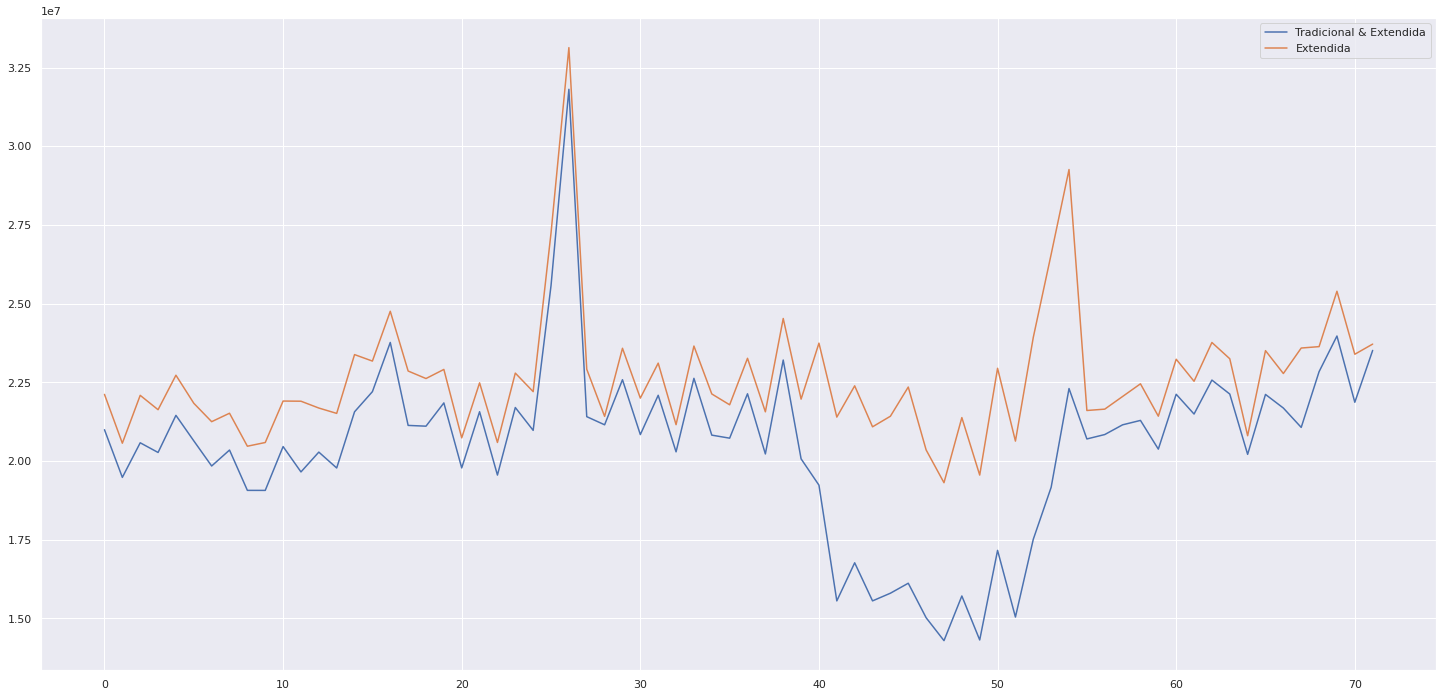

In [ ]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax =ax)

ax.legend(labels =['Tradicional & Extendida', 'Extendida']);

**H8. Lojas abertas durante o feriado de Natal deveriam vender mais.** FALSA Lojas abertas durante o Natal vendem MENOS

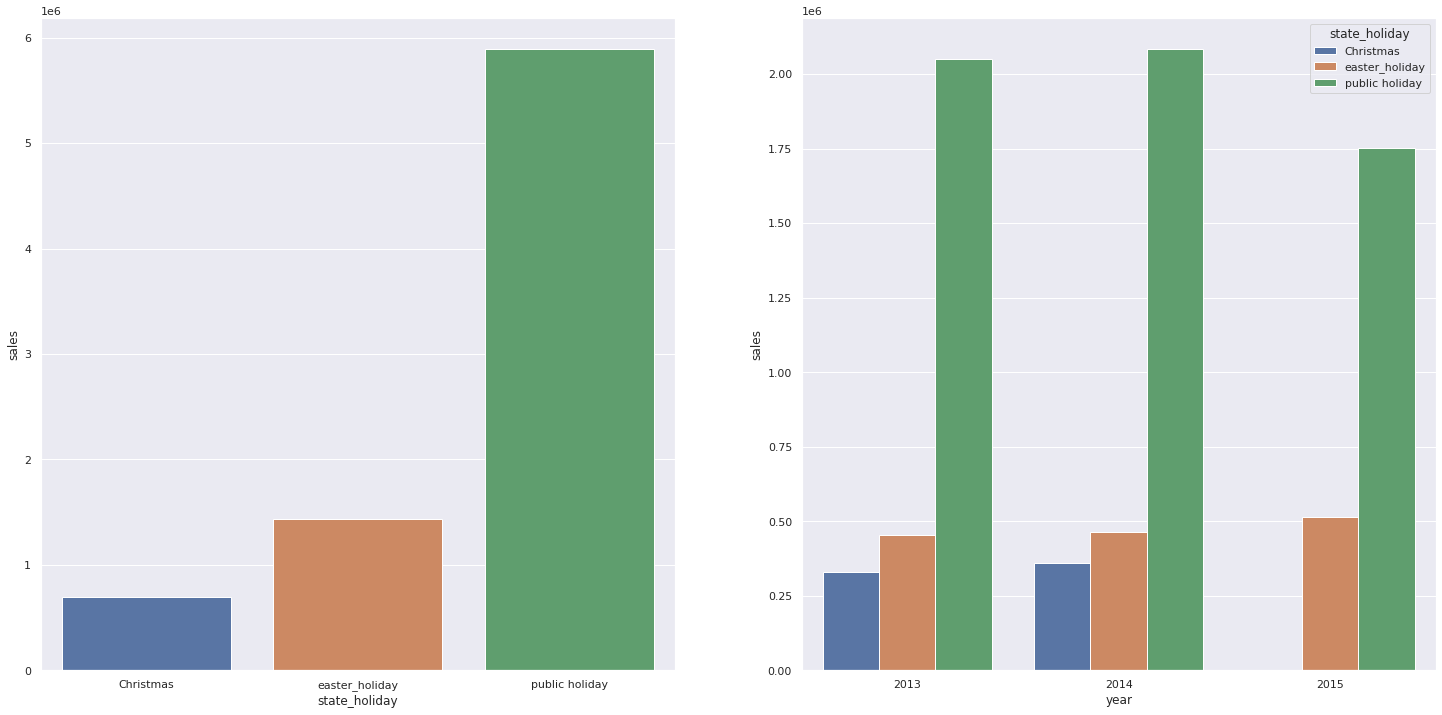

In [ ]:
plt.subplot(1,2,1)
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x = 'state_holiday', y = 'sales', data = aux1);

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x = 'year', y = 'sales', hue = 'state_holiday', data = aux2);

**H9. Lojas deveriam vender mais ao longo dos anos** FALSA Lojas vendem MENOS ao longo dos anos

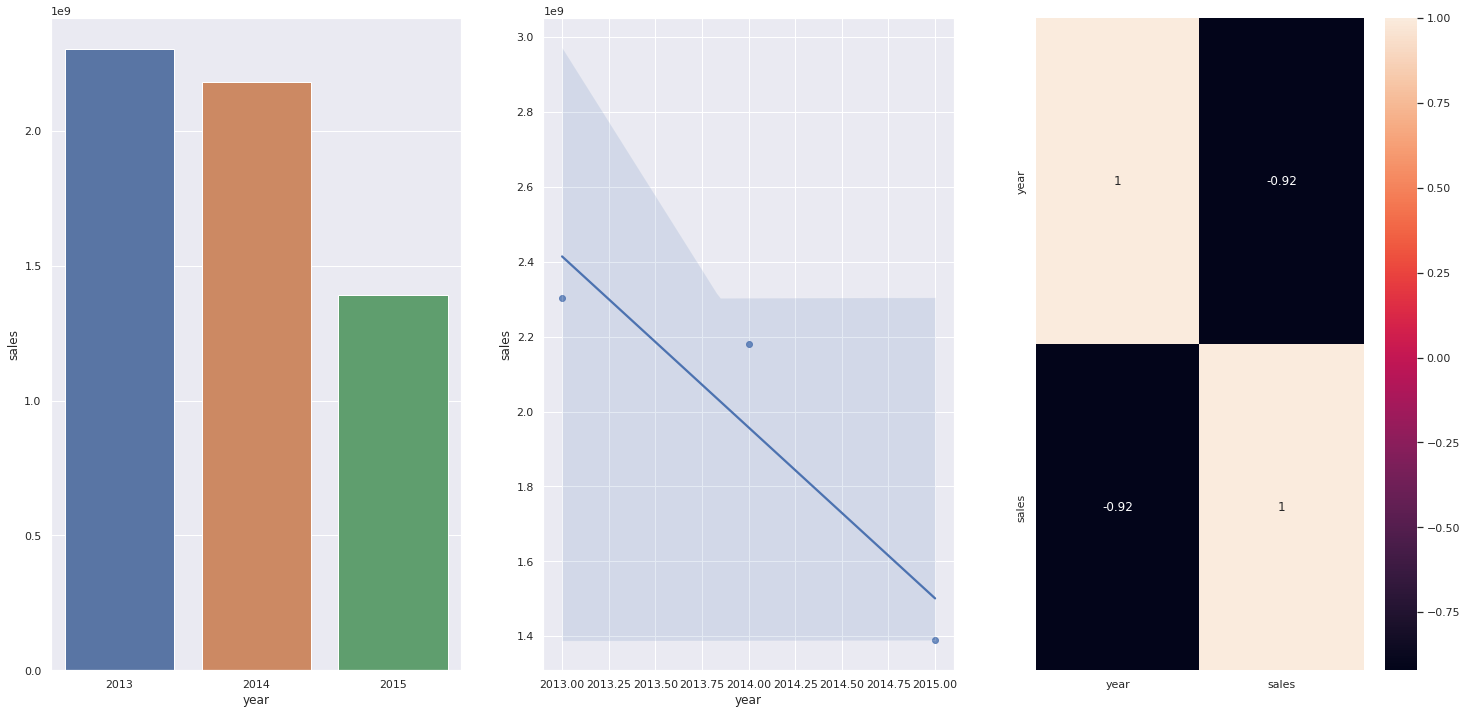

In [ ]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'year', y = 'sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot(x = 'year', y = 'sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

**H10. Lojas deveriam vender mais no segundo semestre do ano.** FALSA Lojas vendem MENOS no segundo semestre do ano

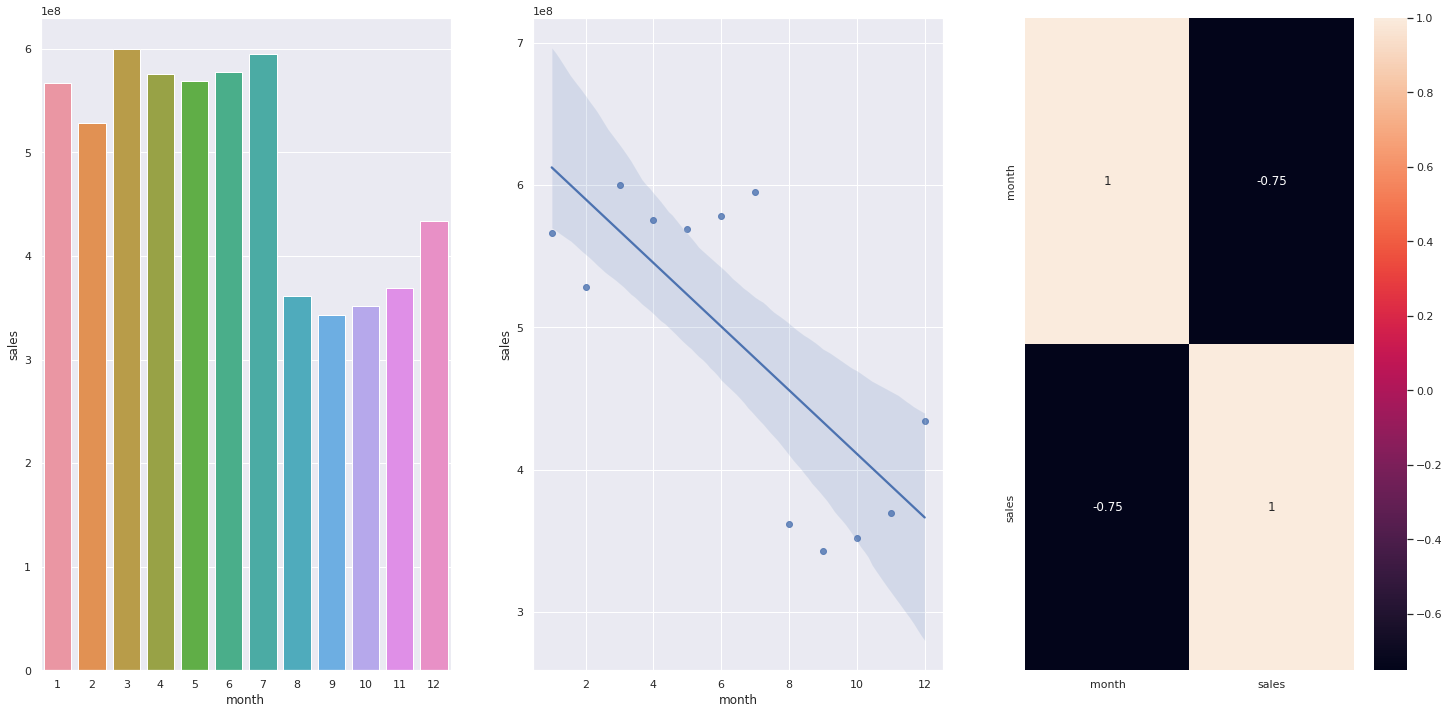

In [ ]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'month', y = 'sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot(x = 'month', y = 'sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

**H11. Lojas deveriam vender mais depois do dia 10 de cada mês.** VERDADEIRA Lojas vendem MAIS depois do dia 10 de cada mês

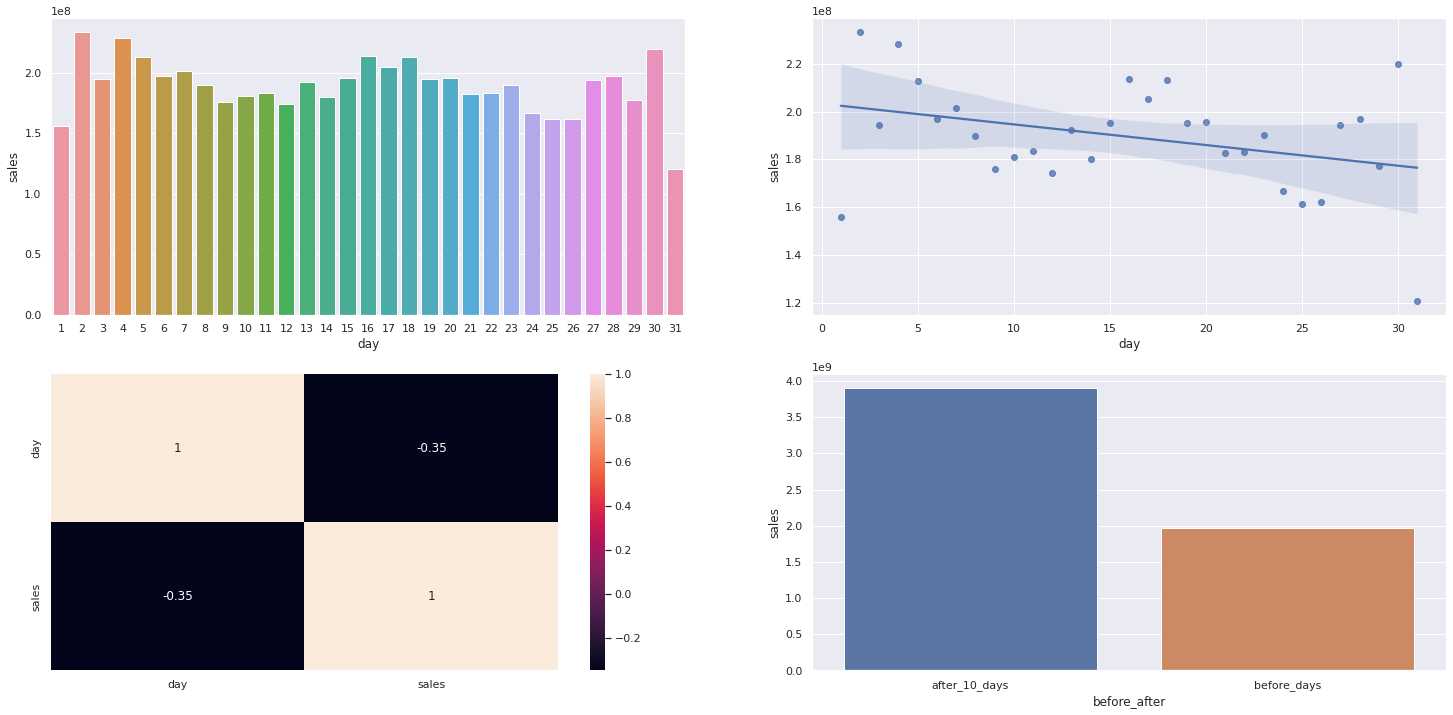

In [ ]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x = 'day', y = 'sales', data = aux1);

plt.subplot(2,2,2)
sns.regplot(x = 'day', y = 'sales', data = aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot= True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_days' if x <=10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x = 'before_after', y = 'sales', data = aux2);

**H12. Lojas deveriam vender menos nos finais de semana.** VERDADEIRA Lojas vendem MENOS nos finais de semana

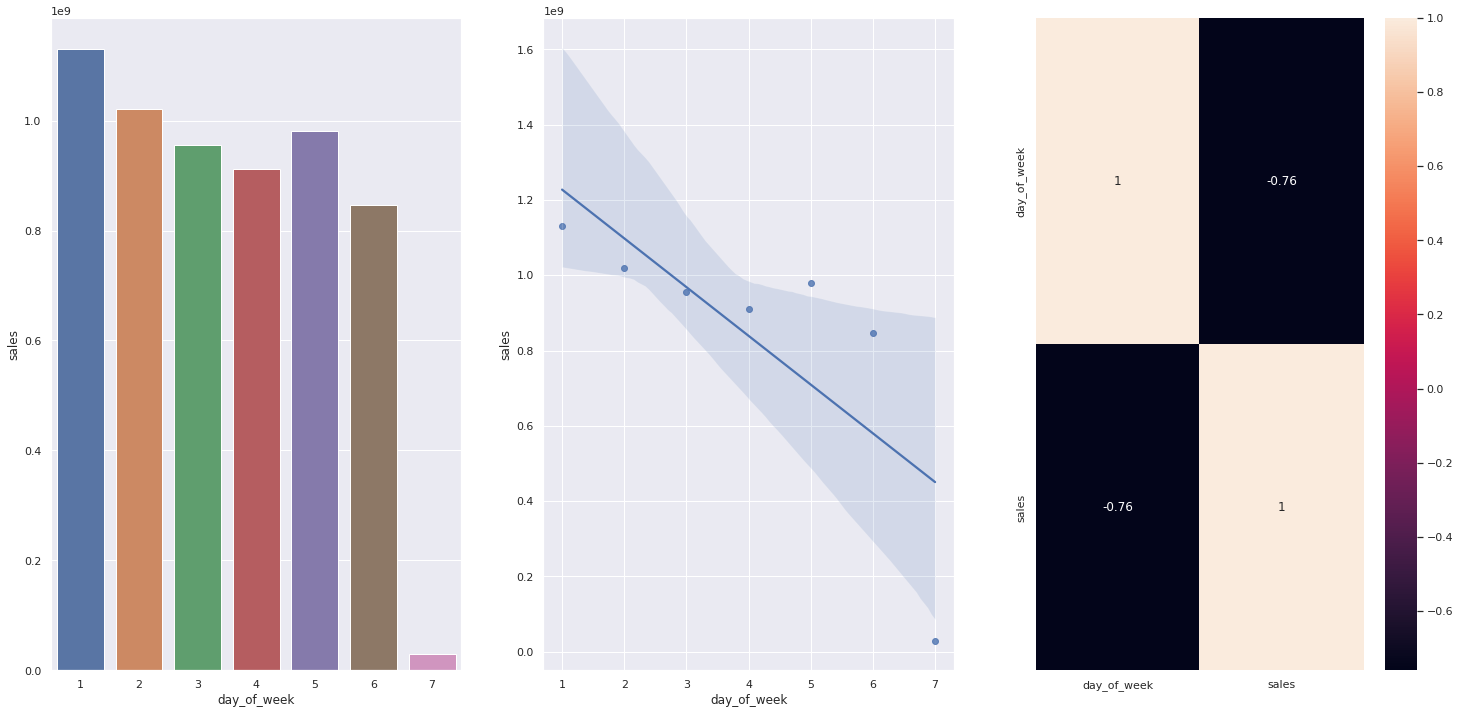

In [ ]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'day_of_week', y = 'sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot(x = 'day_of_week', y = 'sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

**H13. lojas deveriam vender menos durante os períodos escolares** VERDADEIRA lojas vendem MENOS durante os períodos escolares

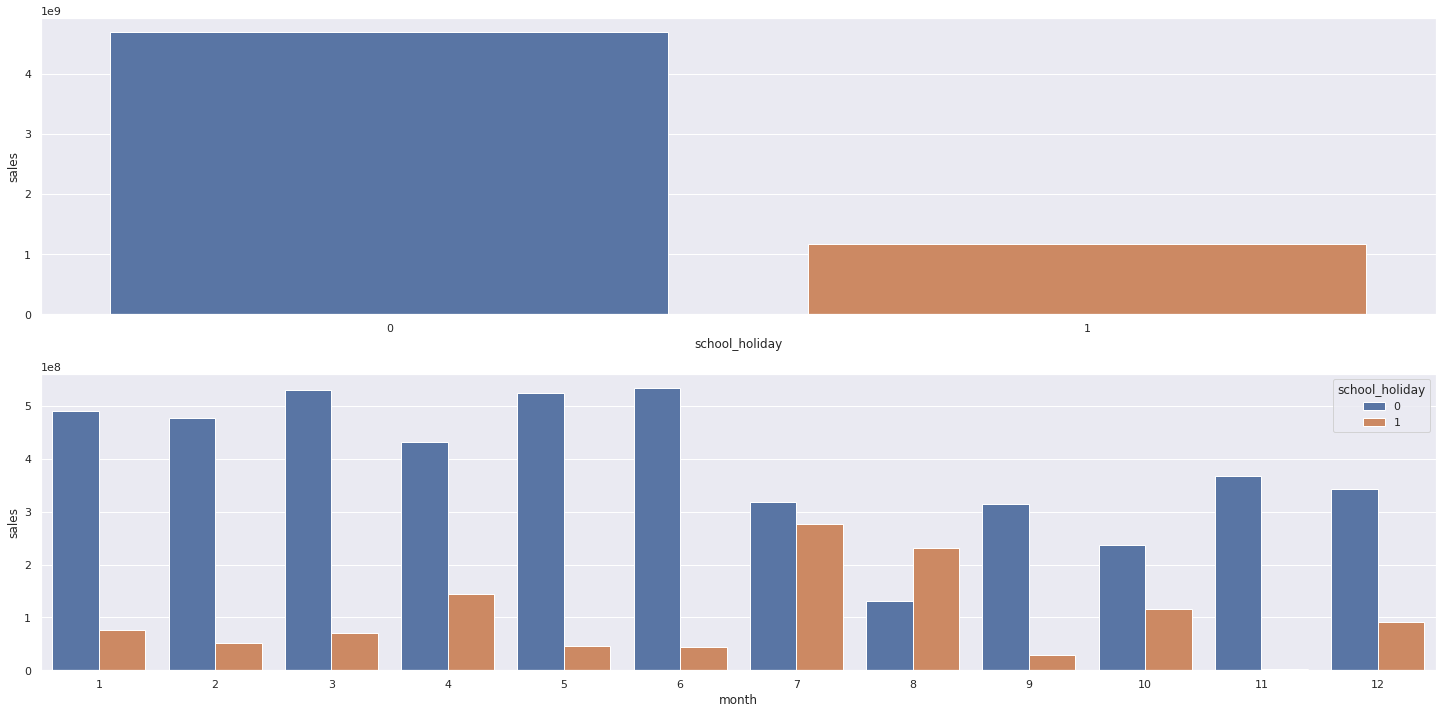

In [ ]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x = 'school_holiday', y = 'sales', data = aux1);

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()

plt.subplot(2,1,2)
sns.barplot(x = 'month', y = 'sales',hue = 'school_holiday', data = aux2);

**4.2.1 Resumo da Hipóteses**

In [ ]:
from tabulate import tabulate

In [ ]:
tab = [['Hipótese', 'Conclusão', 'Relevância'],
    ['H1', 'Falsa', 'Baixa'],
    ['H2', 'Falsa', 'Média'],
    ['H3', 'Falsa', 'Média'],
    ['H4', 'Falsa', 'Baixa'],
    ['H7', 'Falsa', 'Baixa'],
    ['H8', 'Falsa', 'Média'],
    ['H9', 'Falsa', 'Alta'],
    ['H10', 'Falsa', 'Alta'],
    ['H11', 'Verdadeira', 'Alta'],
    ['H12', 'Verdadeira', 'Alta'],
    ['H13', 'Verdadeira', 'Baixa'],
    ]
print(tabulate (tab, headers = 'firstrow'))

Hipótese    Conclusão    Relevância
----------  -----------  ------------
H1          Falsa        Baixa
H2          Falsa        Média
H3          Falsa        Média
H4          Falsa        Baixa
H7          Falsa        Baixa
H8          Falsa        Média
H9          Falsa        Alta
H10         Falsa        Alta
H11         Verdadeira   Alta
H12         Verdadeira   Alta
H13         Verdadeira   Baixa


# **5.0 Data Preparation**

In [ ]:
df5 = df4.copy()

**5.2 Rescaling**

In [ ]:
a = df5.select_dtypes(include = ['int64', 'float64'])

In [ ]:
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


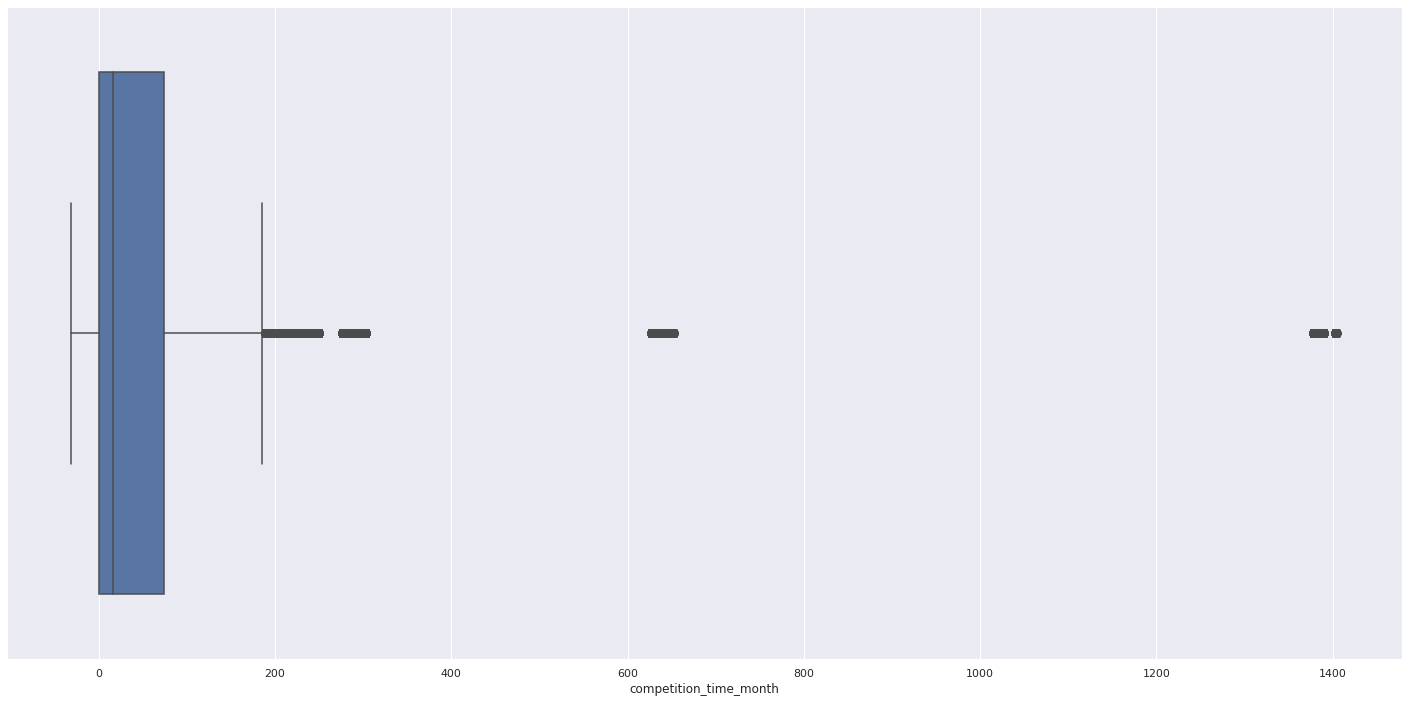

In [ ]:
sns.boxplot(df5['competition_time_month'])

In [ ]:
rs = RobustScaler()
mms = MinMaxScaler()

#competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

#competiton time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

#promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

#year
df5['year'] = mms.fit_transform(df5[['year']].values)

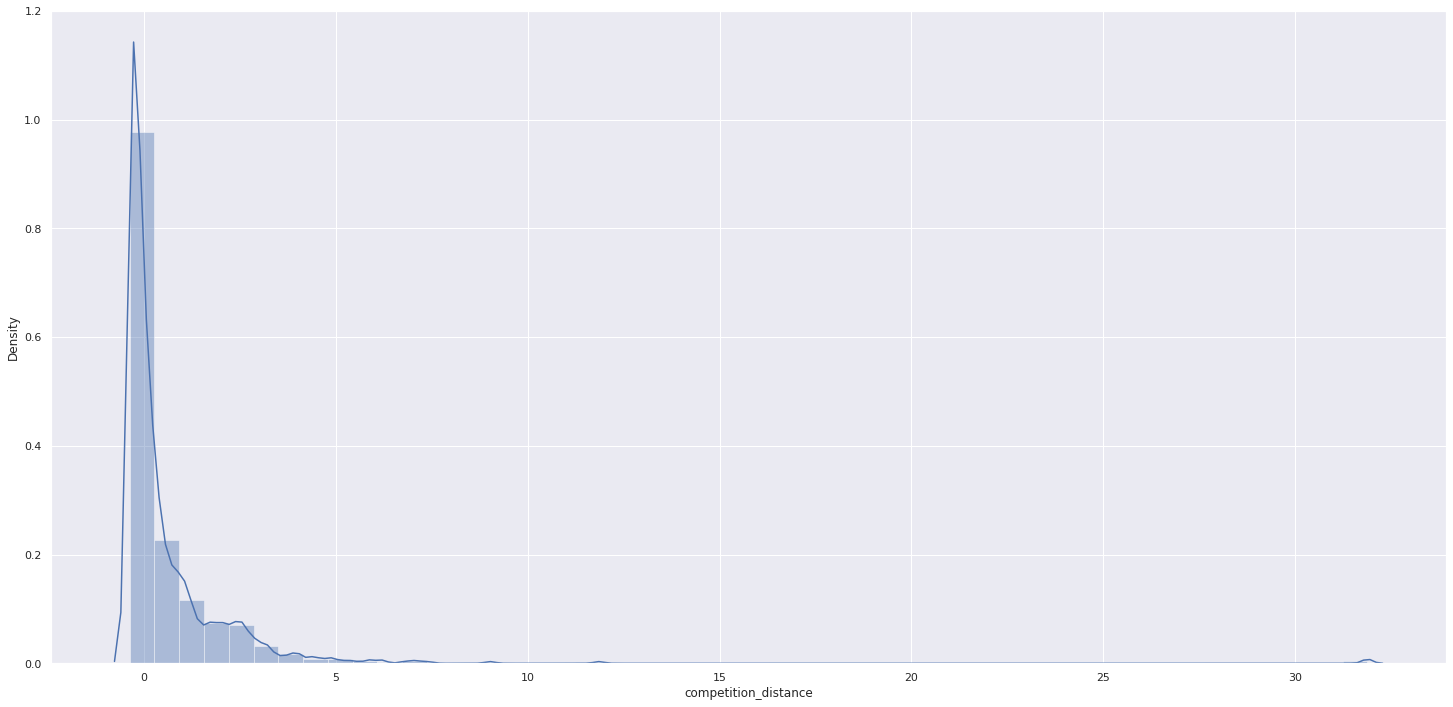

In [ ]:
sns.distplot(df5['competition_distance'])

**5.3 Transformacao**

**5.3.1 Encoding**

In [ ]:
#state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'])

#store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

#assortment - Ordinal Encoding
df5['assortment'].drop_duplicates()

assortment_dict = {'basic':1, 'extra':2, 'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

**5.3.2 Response Variable Transformation**

In [ ]:
df5['sales'] = np.log1p(df5['sales'])

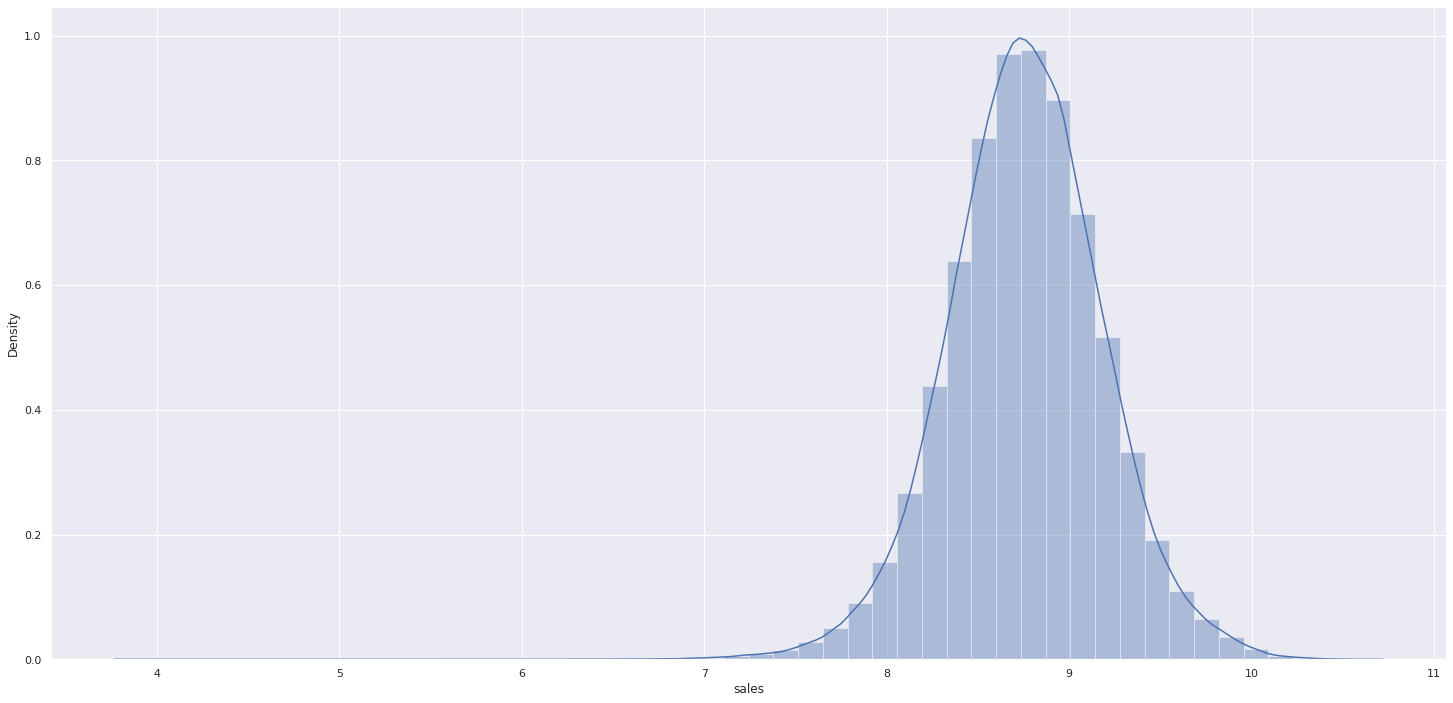

In [ ]:
sns.distplot(df5['sales'])

In [ ]:
#day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x:np.sin(x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x:np.cos(x * (2. * np.pi/7)))

#month
df5['month_sin'] = df5['month'].apply(lambda x:np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x:np.cos(x * (2. * np.pi/12)))

#day
df5['day_sin'] = df5['day'].apply(lambda x:np.sin(x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x:np.cos(x * (2. * np.pi/30)))

#week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x:np.sin(x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x:np.cos(x * (2. * np.pi/52)))

In [ ]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_Christmas,state_holiday_easter_holiday,state_holiday_public holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# **6.0 Feature Selection**

In [ ]:
df6 = df5.copy()

**6.1 Split dataframe into training and test dataset**

In [ ]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis = 1)

In [ ]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( days = 6*7)

Timestamp('2015-06-19 00:00:00')

In [ ]:
#training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

#test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date:{}'.format(X_train['date'].min()))
print('Training Max Date:{}'.format(X_train['date'].max()))

print('\nTest Min Date:{}'.format(X_test['date'].min()))
print('Test Max date:{}'.format(X_test['date'].max()))

Training Min Date:2013-01-01 00:00:00
Training Max Date:2015-06-18 00:00:00

Test Min Date:2015-06-19 00:00:00
Test Max date:2015-07-31 00:00:00


**6.2 Manual feature Selection**

In [ ]:
cols_selected = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_full = cols_selected.copy()
cols_selected_full.extend( feat_to_add )

In [ ]:
cols_selected

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

# **7.0 MACHINE LEARNING MODELLING**

In [ ]:
x_train = X_train[ cols_selected ]
x_test = X_test[ cols_selected ]

**7.1 Average Model**

In [ ]:
def mean_absolute_percentage_error( y, yhat):
    return np.mean(np.abs(( y - yhat )/ y))

def ml_error( model_name, y, yhat):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error (y, yhat ))

    return pd.DataFrame( { 'Model Name' : model_name,
                            'MAE': mae,
                             'MAPE': mape,
                             'RMSE': rmse}, index=[0])

In [ ]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#prediction
aux2 = aux1[['store','sales']].groupby( 'store' ).mean().reset_index().rename( columns = {'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how = 'left', on = 'store')
yhat_baseline = aux1['predictions']

#performance
baseline_result = ml_error( 'Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


**7.2 Linear Regression Model**

In [ ]:
#model
lr = LinearRegression().fit(x_train, y_train)

#prediction
yhat_lr = lr.predict(x_test)

#performnce
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


**7.3 Linear Regression Regularized Model - Lasso**

In [ ]:
#model
lrr = Lasso(alpha = 0.01).fit(x_train, y_train)

#prediction
yhat_lrr = lrr.predict(x_test)

#performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


*** Obs.: Modelo que estamos medindo não é Linear, não é simples. Com isso implementamos os modelos Não-Lineares **

**7.4 Random Forest Regressor**

In [ ]:
#model
rf = RandomForestRegressor(n_estimators = 50, n_jobs=-1, random_state = 42).fit(x_train, y_train)

#prediction
yhat_rf = rf.predict(x_test)

#performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,684.431113,0.10075,1018.684119


**7.5 XGBoost Regressor**

In [ ]:
#model
model_xgb = xgb.XGBRegressor(Objective = 'reg:squarederror',
                            n_estimators = 50,
                            eta = 0.01,
                            max_depth = 10,
                            subsample = 0.7,
                            colsample_bytee = 0.09).fit(x_train, y_train)

#prediction
yhat_xgb = model_xgb.predict(x_test)

#performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

[17:26:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1221.687285,0.168305,1812.583417


# **7.6 Compare Model's Performance**

In [ ]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,684.431113,0.100750,1018.684119
0,XGBoost Regressor,1221.687285,0.168305,1812.583417
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


**Obs.: ** O primeiro modelo é Random Forest Regressor, porém, como utilizamos as 6 últimas semanas como teste e o restante para treino, iremos utilizar o cross-validation para pegar diferentes sessões dos dados.Para uma performance real do modelo.

**7.4 Time Series Cross-Validation**

>> Incluir as variáveis Date , Sales = cols_selected_full

In [ ]:
# Time Series Data Preparation
x_training = X_train[cols_selected_full]

In [ ]:
x_training.head()

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo_time_week,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,date,sales
47945,1,1,2,1,-0.170968,9,2008,0,25,2015,0.891892,0.287016,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,2015-06-18,8.443762
47946,2,1,0,1,-0.283871,11,2007,1,13,2010,1.027027,0.908884,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,2015-06-18,8.547722
47947,3,1,0,1,1.903226,12,2006,1,14,2011,1.189189,0.788155,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,2015-06-18,8.927712
47948,4,1,2,3,-0.275806,9,2009,0,25,2015,0.729730,0.287016,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,2015-06-18,9.091669
47949,5,1,0,1,4.448387,4,2015,0,25,2015,-0.189189,0.287016,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,2015-06-18,8.502080


In [ ]:
x_training['date'].max()

Timestamp('2015-06-18 00:00:00')

**7.4.1 Função cross_validation**

In [ ]:
def cross_validation ( x_training,kfold,model_name,model,verbose=False):
    mae_list=[]
    mape_list=[]
    rmse_list=[]

    for k in reversed(range (1,kfold+1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        #Data inicial e final para validação
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)
        #print('Data Inicial:  {}'.format(validation_start_date))
        #print('Data Final:  {}'.format(validation_end_date))

        #filtrando dados de treinamento
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date']<=validation_end_date)]

        #Tirando as variaveis tempo e vendas para previsão
        #treino
        xtraining=training.drop(['date','sales'],axis=1)
        ytraining=training['sales']

        #validacao
        xvalidation=validation.drop(['date','sales'],axis=1)
        yvalidation=validation['sales']

        ##modelo
        m=model.fit(xtraining,ytraining)
        # predicao
        yhat= m.predict(xvalidation)
        # performance
        m_result = ml_error(model_name,np.expm1(yvalidation),np.expm1(yhat))

        #Salvando resultados nas listas
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
        #print (lr_result)

    return pd.DataFrame(
        {
         'Model Name': model_name,
         'MAE CV': np.round(np.mean(mae_list),2).astype(str)+ '+/-' + np.round( np.std(mae_list),2).astype(str),
         'MAPE CV': np.round(np.mean(mape_list),2).astype(str)+ '+/-' + np.round( np.std(mape_list),2).astype(str),
         'RMSE CV': np.round(np.mean(rmse_list),2).astype(str)+ '+/-' + np.round( np.std(rmse_list),2).astype(str)
        }, index=[0])

**7.4.2 Linear Regression Model - Cross Validation**

In [ ]:
lr_result_cv=cross_validation(x_training,5,'Linear Regression',lr)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73+/-295.63,0.3+/-0.02,2952.52+/-468.37


**7.4.3 Lasso - Cross validation**

In [ ]:
lasso_result_cv=cross_validation(x_training,5,'Lasso',lrr)
lasso_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38+/-341.5,0.29+/-0.01,3057.75+/-504.26


**7.4.4.Random Forest - Cross Validation**

In [ ]:
rf_result_cv=cross_validation(x_training,5,'Random Forest',rf,True)
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,842.56+/-220.07,0.12+/-0.02,1264.33+/-323.29


**7.4.5 XGBoost Regressor - Cross Validation**

In [ ]:
xgb_result_cv=cross_validation(x_training,5,'XGB Boost',model_xgb,True)
xgb_result_cv


KFold Number: 5
[17:55:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

KFold Number: 4
[17:57:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

KFold Number: 3
[18:00:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

KFold Number: 2
[18:02:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

KFold Number: 1
[18:04:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGB Boost,1399.55+/-204.9,0.18+/-0.02,2020.59+/-274.97


**7.4.6 Real Performance - Cross Validation**

In [ ]:
modelling_result_cv= pd.concat([lr_result_cv,lasso_result_cv,rf_result_cv,xgb_result_cv])
modelling_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,842.56+/-220.07,0.12+/-0.02,1264.33+/-323.29
0,XGB Boost,1399.55+/-204.9,0.18+/-0.02,2020.59+/-274.97
0,Linear Regression,2081.73+/-295.63,0.3+/-0.02,2952.52+/-468.37
0,Lasso,2116.38+/-341.5,0.29+/-0.01,3057.75+/-504.26


Obs.: O Random Forest trouxe o melhor modelo, porém usei o XGBoost para análises finais.

# **8.0 Tunning de Hyper Parameter**

**8.1 Random Search**

In [ ]:
param = {'n_estimators': [15,17,25,30,35],
         'eta': [0.01,0.03],
         'max_depth': [3,5,9],
         'subsample': [0.1,0.5,0.7],
         'colsample_bytree': [0.3,0.7,0.9],
         'min_child_weight': [3,8,15]}
MAX_EVAL=5

In [ ]:
rs_result = pd.DataFrame()
for i in range (MAX_EVAL):
    hp = {k: rds.sample(v,1)[0] for k,v in param.items()}
    print(hp)
    model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                                 n_estimators=hp['n_estimators'],
                                 eta=hp['eta'],
                                 max_depth=hp['max_depth'],
                                 subsample=hp['subsample'],
                                colsample_bytree=hp['colsample_bytree'],
                                 min_child_weight=hp['min_child_weight'])


    xgb_result_rs=cross_validation(x_training,5,'XGB Boost',model_xgb,True)
    rs_result=pd.concat([rs_result,xgb_result_rs])
rs_result

{'n_estimators': 25, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 8}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 35, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 15}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 35, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 3}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 35, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 3}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 25, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 15}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Num

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGB Boost,3799.65+/-488.25,0.46+/-0.02,4748.66+/-593.5
0,XGB Boost,2414.46+/-351.63,0.29+/-0.02,3433.91+/-469.17
0,XGB Boost,2414.46+/-351.63,0.29+/-0.02,3433.91+/-469.17
0,XGB Boost,2421.42+/-358.94,0.29+/-0.02,3434.87+/-475.72
0,XGB Boost,3793.68+/-477.98,0.46+/-0.02,4746.68+/-582.87


# **8.2 Final Model**

In [ ]:
x_train_b=x_train[cols_selected]
x_test_b=x_test[cols_selected]

In [ ]:
param_tuned = {'n_estimators':35 ,
               'eta': 0.03,
               'max_depth': 3,
               'subsample':0.5 ,
               'colsample_bytree':0.9,
               'min_child_weight': 3}

In [ ]:
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=param_tuned['n_estimators'],
                             eta=param_tuned['eta'],
                             max_depth=param_tuned['max_depth'],
                             subsample=param_tuned['subsample'],
                             colsample_bytree=param_tuned['colsample_bytree'],
                             min_child_weight=param_tuned['min_child_weight']).fit(x_train_b,y_train)

yhat_xgb_tuned=model_xgb_tuned.predict(x_test_b)

xgb_result_tunes=ml_error('XGBoost Regressor',np.expm1(y_test),np.expm1(yhat_xgb_tuned))
xgb_result_tunes

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,2192.262277,0.280707,3170.927135


In [ ]:
def mean_percentage_error(y,yhat):
    return np.mean( ( y - yhat ) / y )

In [ ]:
mpe  = mean_percentage_error( np.expm1(y_test), np.expm1(yhat_xgb_tuned))
mpe

0.14961084772451572

# **9.0 Tradução e Interpretação do erro**

In [ ]:
df9 = X_test[cols_selected_full]

#backing original data
df9['sales'] = np.expm1 (df9['sales'])
df9['predictions'] = np.expm1 (yhat_xgb_tuned)

**9.1 Perfomance do Negocio**  
Foi utilizado a variável 'store' pois queremos saber a predição de quanto cada loja irá gastar na reforma.

In [ ]:
df91 = df9[['store','predictions']].groupby('store').sum().reset_index()

df9_aux1 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_error( x['sales'],x['predictions'])).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error( x['sales'],x['predictions'])).reset_index().rename( columns={0:'MAPE'})

df9_aux3 = pd.merge(df9_aux1,df9_aux2, how='inner', on='store')

df92 = pd.merge(df91,df9_aux3,how='inner',on='store')

df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

df92=df92[['store','predictions','worst_scenario','best_scenario','MAE','MAPE']]

In [ ]:
df92.sample(4)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
989,990,197238.218750,196153.662255,198322.775245,1084.556495,0.155481
405,406,181296.390625,178853.049818,183739.731432,2443.340807,0.321339
794,795,177447.171875,176766.113657,178128.230093,681.058218,0.179924
375,376,206859.328125,204359.796545,209358.859705,2499.531580,0.289652


In [ ]:
df92.sort_values('MAPE',ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
542,543,193691.218750,191103.455936,196278.981564,2587.762814,1.192619
306,307,178609.468750,176424.509950,180794.427550,2184.958800,1.007519
197,198,163274.546875,161635.840688,164913.253062,1638.706187,1.007343
969,970,178247.609375,176210.863321,180284.355429,2036.746054,0.958690
424,425,208418.609375,205949.457651,210887.761099,2469.151724,0.865020


Obs.: A predição é o quanto a loja irá somar de receita na próxima semana, com erro de MAPE, e pior cenário e melhor cenário.

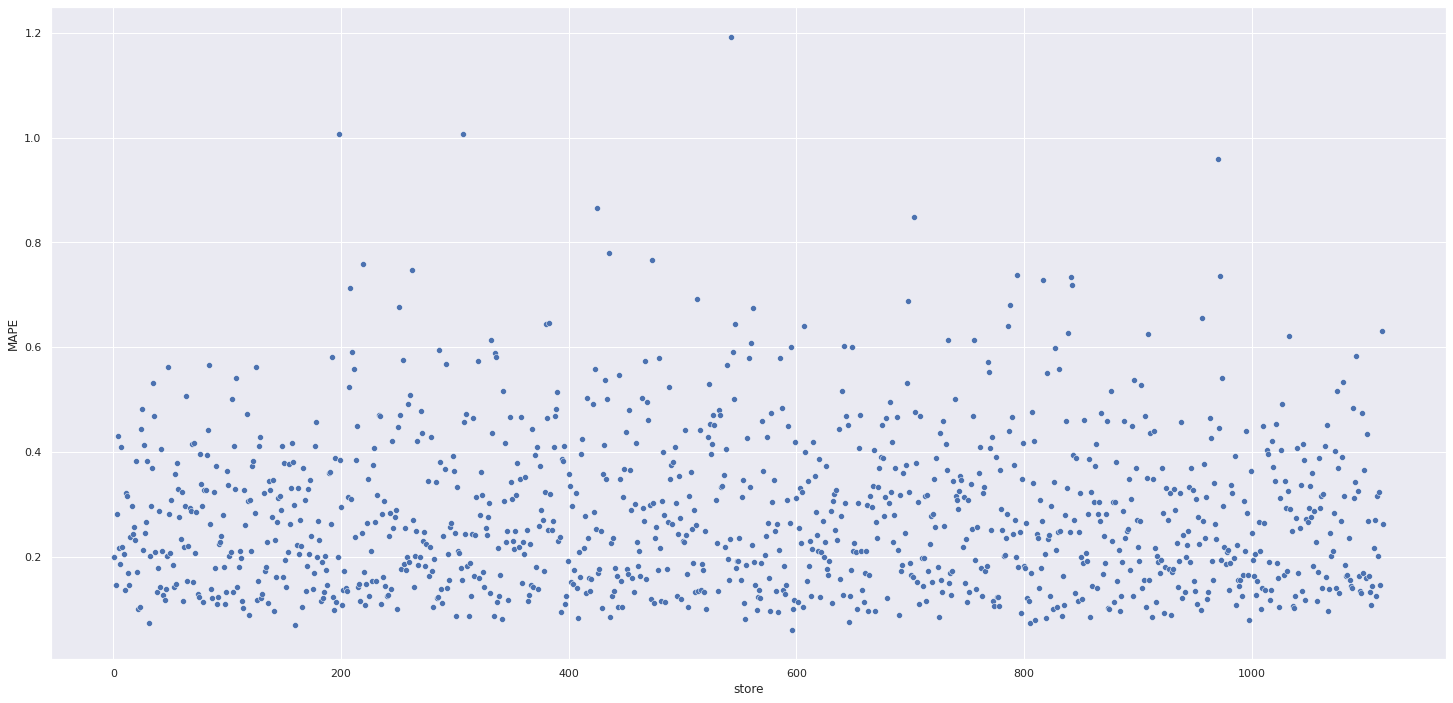

In [ ]:
sns.scatterplot(x='store',y='MAPE',data=df92)

**9.2 Perfomance Geral**

In [ ]:
df93 = df92[['predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum(x),axis=0).reset_index().rename( columns = {'index':'Scenario', 0 :'Values'})
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"R$216,636,640.00"
1,worst_scenario,"R$214,197,780.77"
2,best_scenario,"R$219,075,467.82"


**RESULTADO FINAL: Predição em todas as lojas nas próximas 6 semanas:  216.636.640,00. Pior cenário: 214.197.780,77 - Melhor cenário: 219.075.467,82**

**9.3 Perfomance do ML**

In [ ]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['sales'] / df9['predictions']

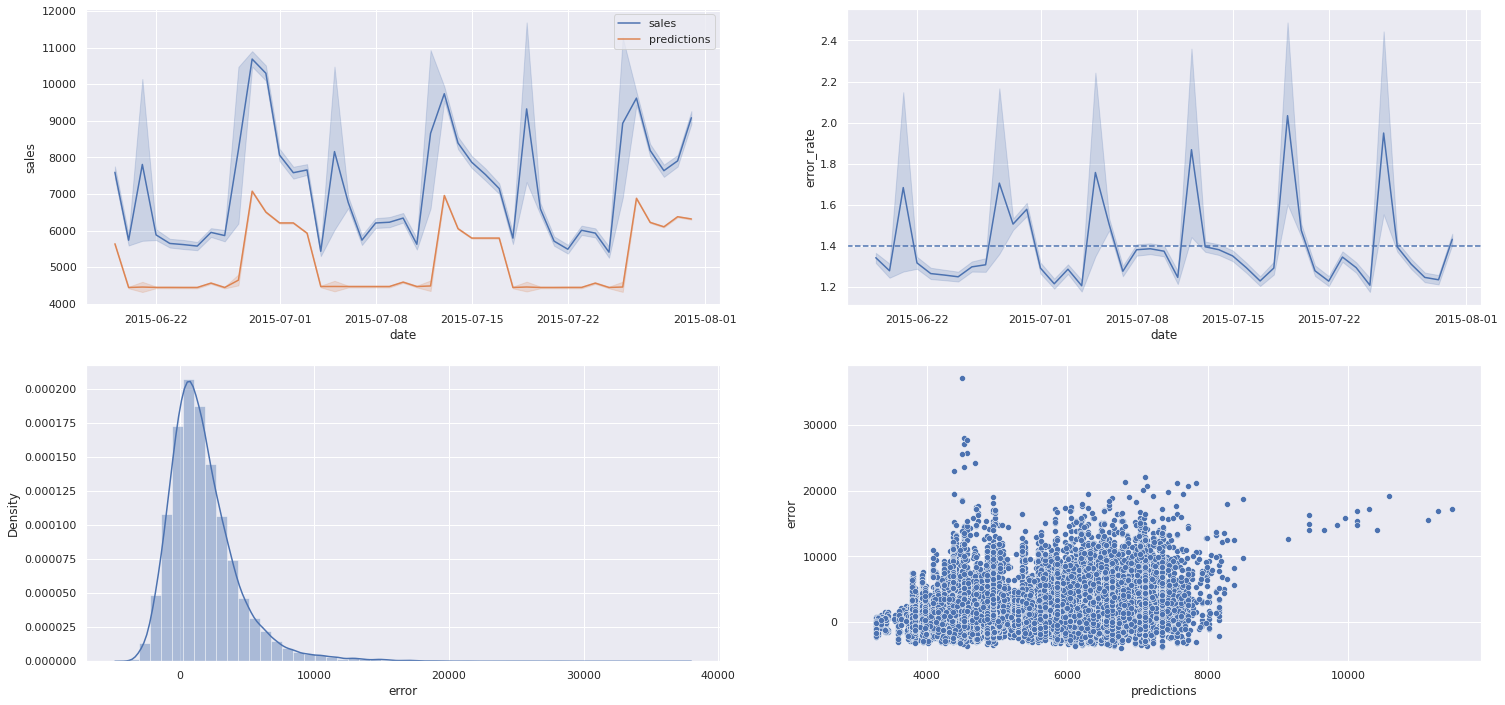

In [ ]:
plt.subplot(2,2,1)
sns.lineplot(x='date',y='sales',data=df9,label='sales')
sns.lineplot(x='date',y='predictions',data=df9,label='predictions')

plt.subplot(2,2,2)
sns.lineplot(x='date',y='error_rate',data=df9)
plt.axhline( 1.4, linestyle='--')

plt.subplot(2,2,3)
sns.distplot(df9['error'])

plt.subplot(2,2,4)
sns.scatterplot(x=df9['predictions'],y=df9['error'])

Primeiro gráfico: Mostra as predições das 6 semanas - Cor laranja: predições - Azul: vendas reais.

Segundo gráfico: Predição em relação as vendas, acima da linha pontilhada está subestimada.

Terceiro gráfico: Distribuição do erro, próximo da gaussiana, próxima da normal.

Quarto gráfico: Análise de resíduo para melhorar o modelo.Predições em relação ao erro. Predições próximas a ~4000 e ~7000 sempre tem erros maiores como mostrado no gráfico. No caso, tem que rever o modelo para "extender" mais o gráfico.

# **Referências**

https://www.kaggle.com/c/rossmann-store-sales

Livros:
- Introdução a Data Science: Algoritmos de Machine Learning e métodos de análise  - Tatiana Escovedo, Adriano Koshiyama

- Hands-On Machine Learning with Scikit-Learn, Keras, and Tensorflow: Concepts, Tools, and Techniques to Build Intelligent Systems - Aurélien Géron

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score